<a href="https://colab.research.google.com/github/coopercunliffe/springboard/blob/master/president_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
import re
from fastai.text import *

pd.set_option('display.max_colwidth', 80)

random.seed(22)

In [0]:
# mount google drive

In [0]:
df = pd.read_csv('/content/drive/My Drive/twitter data/tweet_df.csv', lineterminator='\n', index_col=0)

In [22]:
df.shape

(48151, 28)

In [23]:
# trump tweets only, no retweets
df = df[df['is_retweet'] == False]
df.shape

(41921, 28)

In [24]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,created_date,created_time,created_hour,created_hour_est,is_presidential,is_valid,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_quarter_start,created_at_Is_year_end,created_at_Is_year_start,created_atElapsed,created_at_Dayofweek_str
0,Twitter Web Client,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,2009-05-04 18:54:25+00:00,253,NaN,202,False,2009-05-04,18:54:25,18,14,False,False,2009,5,19,4,0,124,False,False,False,False,False,False,1241463265,Monday
1,Twitter Web Client,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,2009-05-05 01:00:10+00:00,2,NaN,3,False,2009-05-05,01:00:10,1,21,False,False,2009,5,19,5,1,125,False,False,False,False,False,False,1241485210,Tuesday
2,Twitter Web Client,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,2009-05-08 13:38:08+00:00,3,NaN,2,False,2009-05-08,13:38:08,13,9,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241789888,Friday
3,Twitter Web Client,1741160716,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,2009-05-08 20:40:15+00:00,8,NaN,27,False,2009-05-08,20:40:15,20,16,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241815215,Friday
4,Twitter Web Client,1773561338,"""My persona will never be that of a wallflower - I’d rather build walls than...",2009-05-12 14:07:28+00:00,1421,NaN,1950,False,2009-05-12,14:07:28,14,10,False,False,2009,5,20,12,1,132,False,False,False,False,False,False,1242137248,Tuesday


In [0]:
# Validation data will start as most recent 20% of the tweets

test_size = len(df['is_valid']) // 5 

df['is_valid'].iloc[-test_size:] = True    

In [26]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,created_date,created_time,created_hour,created_hour_est,is_presidential,is_valid,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_quarter_start,created_at_Is_year_end,created_at_Is_year_start,created_atElapsed,created_at_Dayofweek_str
0,Twitter Web Client,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,2009-05-04 18:54:25+00:00,253,NaN,202,False,2009-05-04,18:54:25,18,14,False,False,2009,5,19,4,0,124,False,False,False,False,False,False,1241463265,Monday
1,Twitter Web Client,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,2009-05-05 01:00:10+00:00,2,NaN,3,False,2009-05-05,01:00:10,1,21,False,False,2009,5,19,5,1,125,False,False,False,False,False,False,1241485210,Tuesday
2,Twitter Web Client,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,2009-05-08 13:38:08+00:00,3,NaN,2,False,2009-05-08,13:38:08,13,9,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241789888,Friday
3,Twitter Web Client,1741160716,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,2009-05-08 20:40:15+00:00,8,NaN,27,False,2009-05-08,20:40:15,20,16,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241815215,Friday
4,Twitter Web Client,1773561338,"""My persona will never be that of a wallflower - I’d rather build walls than...",2009-05-12 14:07:28+00:00,1421,NaN,1950,False,2009-05-12,14:07:28,14,10,False,False,2009,5,20,12,1,132,False,False,False,False,False,False,1242137248,Tuesday


In [0]:
# Randnomize which tweets make it into the validation set

df['is_valid'] = random.sample(list(df['is_valid']), len(df['is_valid']))

In [28]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,created_date,created_time,created_hour,created_hour_est,is_presidential,is_valid,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_quarter_start,created_at_Is_year_end,created_at_Is_year_start,created_atElapsed,created_at_Dayofweek_str
0,Twitter Web Client,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,2009-05-04 18:54:25+00:00,253,NaN,202,False,2009-05-04,18:54:25,18,14,False,False,2009,5,19,4,0,124,False,False,False,False,False,False,1241463265,Monday
1,Twitter Web Client,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,2009-05-05 01:00:10+00:00,2,NaN,3,False,2009-05-05,01:00:10,1,21,False,False,2009,5,19,5,1,125,False,False,False,False,False,False,1241485210,Tuesday
2,Twitter Web Client,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,2009-05-08 13:38:08+00:00,3,NaN,2,False,2009-05-08,13:38:08,13,9,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241789888,Friday
3,Twitter Web Client,1741160716,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,2009-05-08 20:40:15+00:00,8,NaN,27,False,2009-05-08,20:40:15,20,16,False,True,2009,5,19,8,4,128,False,False,False,False,False,False,1241815215,Friday
4,Twitter Web Client,1773561338,"""My persona will never be that of a wallflower - I’d rather build walls than...",2009-05-12 14:07:28+00:00,1421,NaN,1950,False,2009-05-12,14:07:28,14,10,False,False,2009,5,20,12,1,132,False,False,False,False,False,False,1242137248,Tuesday


In [0]:
# make df of label, text, is_valid 

# label will be 'is_night_tweet' (10pm - 6am EST)


texts = df[['is_presidential', 'text', 'is_valid']] 

In [0]:
texts = texts.rename(columns={'is_presidential':'label'})

In [31]:
texts[texts['label'] == True].shape

(11785, 3)

In [32]:
texts[texts['label'] == False].shape

(30136, 3)

In [33]:
texts.head()

,label,text,is_valid
0,False,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,False
1,False,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,False
2,False,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,False
3,False,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,True
4,False,"""My persona will never be that of a wallflower - I’d rather build walls than...",False


In [0]:
# Ramdomize the rows to destroy any temporal information

texts = texts.sample(frac=1)

In [0]:
texts = texts.reset_index(drop=True)

In [36]:
texts.head()

,label,text,is_valid
0,False,I will write a $2 MILLION check to our campaign if we hit our million-dollar...,False
1,True,"Great job, just in time! https://t.co/KMUXtO8IYz",False
2,False,.@GOP has leverage. Must stay united &amp; on message.,False
3,False,"""@cisrabbit: Not to mention we already had two Bush presidents, neither of w...",False
4,False,"Within the heart of beautiful Somerset County, Trump Nat’l Bedminster is the...",False


In [0]:
#  Define Path and separate the training and validation data

path = Path('/content/drive/My Drive') 

train_df, valid_df = texts[texts['is_valid'] == False], texts[texts['is_valid'] == True]

In [38]:
# create data bunches

data_lm = TextLMDataBunch.from_df(path, train_df, valid_df, text_cols=1, bs=32)
data_clas = TextClasDataBunch.from_df(path, train_df, valid_df, text_cols=1, label_cols=0, bs=32)

In [39]:
data_lm.show_batch()
data_clas.show_batch()

idx,text
0,"not to mention we already had two xxmaj bush presidents , neither of which were too successful . xxmaj insanity would be to want a third . "" xxbos xxmaj within the heart of beautiful xxmaj somerset xxmaj county , xxmaj trump xxmaj nat’l xxmaj bedminster is the proud host of the 2022 @pgachampionship http : / / t.co / o4bycblewo xxbos xxmaj george xxmaj will was pushing for @jonhuntsman"
1,"’s xxmaj right . ” https : / / t.co / xxunk xxbos "" xxunk : @realdonaldtrump attended xxmaj tax xxmaj xxunk xxmaj tax xxmaj seminar xxmaj trump xxmaj university . xxmaj changed my life ! ! ! xxmaj able to open my own company xxmaj xxunk xxmaj group xxbos i really enjoyed the debate tonight even though the @foxnews trio , especially @megynkelly , was not very good or"
2,"xxmaj carolina- thank you ! xxmaj heading to xxmaj johnstown , xxmaj pennsylvania now ! xxmaj get out on xxmaj november 8th … https : / / t.co / xxunk xxbos xxmaj newest xxmaj poll : xxmaj only 11 % in favor of starting ridiculous impeachment hearings . xxmaj well , let ’s see : xxmaj we have the xxmaj best xxmaj economy in xxmaj history , the xxmaj best"
3,"xxbos xxmaj leadership : xxmaj whatever happens , you 're responsible . xxmaj if it does n't happen , you 're responsible . xxbos xxmaj one thing has now been proven . xxmaj the xxmaj democrats do not care about xxmaj open xxmaj borders and all of the crime and drugs that xxmaj open xxmaj borders bring ! xxbos "" @danscavino : .@realdonaldtrump xxup rt : “ @tmz_sports : xxmaj"
4,"trump urges xxup gop to be ' mean as hell ' "" http : / / t.co / xxunk xxmaj via @cnnpolitics xxbos xxmaj the economy of the xxmaj united xxmaj states is stronger than ever before ! xxbos xxmaj looking forward to being interviewed by xxmaj sam xxmaj xxunk tomorrow at xxunk in xxmaj sioux xxmaj city at xxup 10am xxup ct ! xxmaj let ’s xxmaj make xxmaj"


text,target
"xxbos xxup house xxup republicans xxup should xxup pass xxup the xxup strong xxup but xxup fair xxup immigration xxup bill , xxup known xxup as xxup goodlatte xxup ii , xxup in xxup their xxup afternoon xxup vote xxup today , xxup even xxup though xxup the xxup dems xxup won’t xxup let xxup it xxup pass xxup in xxup the xxup senate . xxup passage xxup will xxup",True
"xxbos xxmaj to the @navalacademy xxmaj class of 2018 , i say : xxmaj we know you are up to the task . xxmaj we know you will make us proud . xxmaj we know that glory will be yours . xxmaj because you are xxup winners , you are xxup warriors , you are xxup fighters , you are xxup champions , and xxup you will lead us to",True
"xxbos xxrep 5 . are there no “ xxmaj high xxmaj crimes and xxmaj misdemeanors , ” there are no xxmaj crimes by me at all . xxmaj all of the xxmaj crimes were committed by xxmaj crooked xxmaj hillary , the xxmaj dems , the xxup dnc and xxmaj dirty xxmaj cops - and we caught them in the act ! xxmaj we waited for xxmaj mueller and xxup",True
"xxbos @marklevinshow xxmaj mark xxmaj levin : “ xxmaj we ought to talk about the substance of this phone call . xxmaj we have the call , i do n’t know what we need witnesses for ? xxmaj ca n’t we read xxmaj english ? xxmaj do i need a xxmaj whistleblower to tell me what i ’m reading ? xxmaj do i need a xxmaj lt . xxup c.",True
"xxbos xxmaj watch xxmaj mark xxmaj levin interview of xxmaj charlie xxmaj kirk tonight at 11:00 xxup p.m. on @foxnews . xxmaj amazing ! ! ! xxmaj and , while you ’re at it , go get xxmaj charlie ’s new book , “ xxmaj the xxup maga xxmaj doctrine : xxmaj the xxmaj only xxmaj ideas xxmaj that xxmaj will xxmaj win the xxmaj xxunk ... xxmaj this is",True


In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
data_lm = load_data(path, 'data_lm_export.pkl')
data_clas = load_data(path, 'data_clas_export.pkl', bs=32)

In [0]:
# Train a language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


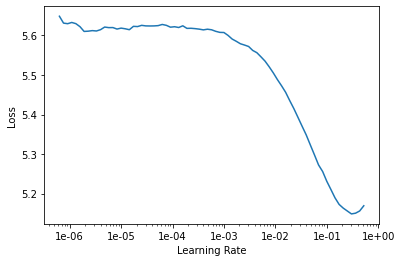

In [49]:
learn.recorder.plot(skip_end=15)

In [50]:
learn.fit_one_cycle(1, 1e-2) # one time through without last layer

epoch,train_loss,valid_loss,accuracy,time
0,3.750671,3.440578,0.360052,00:30


In [51]:
learn.unfreeze() # train full network
learn.fit_one_cycle(1, 1e-3) # low learning rate stops weights from changing too much (10x smaller)

epoch,train_loss,valid_loss,accuracy,time
0,3.264095,3.183439,0.396161,00:36


In [53]:
learn.predict("It's wonderful that", n_words=15)

"It's wonderful that Hillary ’s lies and lack of rove , turned down by so many ratings"

In [0]:
learn.save_encoder('ft_enc')

In [55]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (33537 items)
x: TextList
xxbos i will write a $ 2 xxup million check to our campaign if we hit our million - dollar end - of - month goal ! https : / / t.co / futugi2r2k,xxbos xxmaj great job , just in time ! https : / / t.co / xxunk,xxbos xxup .@gop has leverage . xxmaj must stay united & & on message .,xxbos " xxunk : xxmaj not to mention we already had two xxmaj bush presidents , neither of which were too successful . xxmaj insanity would be to want a third . ",xxbos xxmaj within the heart of beautiful xxmaj somerset xxmaj county , xxmaj trump xxmaj nat’l xxmaj bedminster is the proud host of the 2022 @pgachampionship http : / / t.co / o4bycblewo
y: CategoryList
False,True,False,False,False
Path: /content/drive/My Drive;

Valid: LabelList (8384 items)
x: TextList
xxbos xxmaj the ratings for xxmaj the xxmaj view are really low . xxmaj nicole xxmaj wallace and xxmaj xxunk xxmaj xxunk are a disaster . xxmaj get new cast or just put 

In [56]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.514528,0.284141,0.886093,00:20


In [57]:
# unfreeze last two layers and fine-tune
learn.freeze_to(-2)

 # train the first layers at lr ... and the last layers at lr .. and the rest in between
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.378303,0.203288,0.937858,00:23


In [58]:
learn.unfreeze() # fine tune all the layers 
learn.fit_one_cycle(10, slice(2e-3/100, 2e-3)) # run this twice to max out accuracy

epoch,train_loss,valid_loss,accuracy,time
0,0.426674,0.175663,0.939885,00:50
1,0.383123,0.166014,0.940124,00:54
2,0.369085,0.161757,0.945253,00:52
3,0.325295,0.135027,0.960878,00:48
4,0.327484,0.127610,0.957538,00:52
5,0.217986,0.147739,0.955272,00:50
6,0.212651,0.110524,0.960997,00:53
7,0.160945,0.119675,0.959924,00:50
8,0.182971,0.123890,0.958254,00:50
9,0.138539,0.105388,0.962190,00:52


In [69]:
# is it presidential?

# 0 is False, 1 is True

learn.predict('Governor @GavinNewsom of California won’t let restaurants, beaches and stores open, \
                but he installs a voting both system in a highly Democrat area (supposed to be mail in \
                ballots only) because our great candidate, @MikeGarcia2020, is winning by a lot. CA25  Rigged Election!') # 5/9/2020

(Category tensor(1), tensor(1), tensor([0.2410, 0.7590]))

In [60]:
print(data_clas.classes)

[False, True]


In [61]:
learn.predict('Women for Trump co-chair: Biden might not be ultimate nominee, and Dems engaging in elder abuse')

(Category tensor(0), tensor(0), tensor([0.9755, 0.0245]))

In [62]:
type(learn.predict('hello'))

tuple

In [0]:
# get predictions for each training sample

# choose a certain threshold and look at the samples that have very high and very low probabilities

# do word clouds for them? Or just look at the tweets

In [0]:
# TFIDF matrix ?? 

In [0]:
train_df.shape

(33537, 3)

In [0]:
valid_df.shape

(8384, 3)

In [0]:
texts.columns

Index(['label', 'text', 'is_valid'], dtype='object')

In [0]:
# texts['label_predict'] = [learn.predict(i) for i in texts['text']]
train_df_predictions = []

for tweet in train_df.text:
  train_df_predictions.append(learn.predict(tweet))
  if len(train_df_predictions) % 100 == 0:
    print('predicted so far: ' + str(len(train_df_predictions)))

In [0]:
train_df['predictions_2'] = train_df_predictions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
train_df

,label,text,is_valid,predictions_2
0,True,The riots in Charlottesville a year ago resulted in senseless death and divi...,False,"(True, tensor(1), [tensor(0.2749), tensor(0.7251)])"
1,False,"""@golf_com: .@realDonaldTrump's NYC course just opened, and it is spectacula...",False,"(False, tensor(0), [tensor(0.9959), tensor(0.0041)])"
2,False,"""@rick_royer: @realDonaldTrump on point as always""",False,"(False, tensor(0), [tensor(0.9966), tensor(0.0034)])"
3,True,"The American people deserve to know who is in this Country. Yesterday, the S...",False,"(True, tensor(1), [tensor(0.3453), tensor(0.6547)])"
4,False,"""@SassyPantsjj Please do more Apprentices', know you're busy but once a year...",False,"(False, tensor(0), [tensor(0.9984), tensor(0.0016)])"
...,...,...,...,...
41913,False,"""@Chris_R_2014: @megynkelly @realDonaldTrump - He would fix this complete me...",False,"(False, tensor(0), [tensor(0.9982), tensor(0.0018)])"
41914,False,".@tedcruz must be doing something right if @cher, sadly rated “the 4th uglie...",False,"(False, tensor(0), [tensor(0.9800), tensor(0.0200)])"
41915,True,"...said was a total lie, but Fake Media won’t show it. I am an innocent man ...",False,"(True, tensor(1), [tensor(6.1935e-18), tensor(1.)])"
41916,False,Now he has made his Busey-ism into a song. #CelebApprentice,False,"(False, tensor(0), [tensor(0.9853), tensor(0.0147)])"


In [0]:
# train_df.to_csv('/content/drive/My Drive/twitter data/train_df_2.csv')

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33537 entries, 0 to 41920
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     33537 non-null  bool  
 1   text      33537 non-null  object
 2   is_valid  33537 non-null  bool  
dtypes: bool(2), object(1)
memory usage: 589.5+ KB


In [66]:
interp = TextClassificationInterpretation.from_learner(learn) 

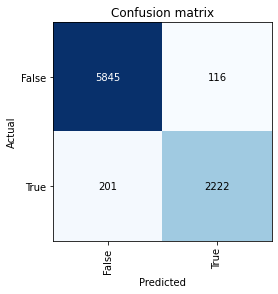

In [67]:
interp.plot_confusion_matrix()

In [70]:
interp.show_intrinsic_attention('Governor @GavinNewsom of California won’t let restaurants, beaches and stores open, \
                but he installs a voting both system in a highly Democrat area (supposed to be mail in \
                ballots only) because our great candidate, @MikeGarcia2020, is winning by a lot. CA25  Rigged Election!')

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
